## GAN model

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set R, G is the generator, trying to create fake data that looks just like the genuine data, while D is the discriminator, getting data from either the real set or G and labeling the difference. Goodfellow’s metaphor (and a fine one it is) was that G was like a team of forgers trying to match real paintings with their output, while D was the team of detectives trying to tell the difference. (Except that in this case, the forgers G never get to see the original data — only the judgments of D. They’re like blind forgers.)

![GAN](https://raw.githubusercontent.com/manhlab/practike-gan-2021/main/gan-mnist.png)

Here's what we're going to do:

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
 - For discriminator
 -  For generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

![MNIST](https://i.imgur.com/CAYnuo1.jpeg)

### Define parameters & Load Dataset 

In [1]:
import torch 
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from IPython.display import Image
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import os
%matplotlib inline 
plt.style.use("ggplot")
hidden_size = 256 
batch_size = 100 
LR = 0.0002
num_epochs = 100
sample_dir = "./images"
latent_size = 64 # input random input vector latent
image_size = 784 # 28*28 flatten
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
  !nvidia-smi
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

Sun Nov 28 14:43:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    31W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.7354248 , -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.4551634 ,  0.587451  ,  0.71973854,  0.85202616,
         0.9843137 ], dtype=float32),
 <a list of 15 Patch objects>)

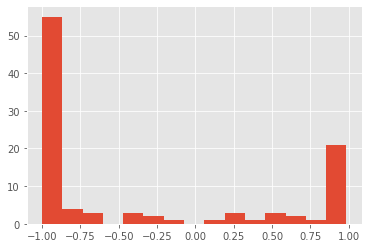

In [2]:
img, label = mnist[0]
print('Label: ', label)
plt.hist(img[:,5:15,5:15].flatten(), bins=15)

In [3]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return x * 0.5 + 0.5

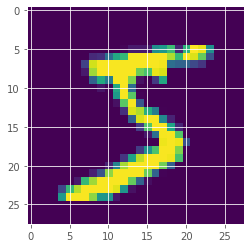

In [4]:
# show  image sample with matplotlib
plt.imshow(denorm(img)[0])
plt.show()

In [5]:
# define the dataloader
data_loader = DataLoader(mnist, batch_size, shuffle=True)

GAN состоит из двух глубоких сетей, генератора и дискриминатора. генератор создает изображения, прежде чем научиться его обучать. Поскольку дискриминатор представляет собой модель бинарной классификации, мы можем использовать функцию потери бинарной кросс-энтропии для количественной оценки того, насколько хорошо он может различать реальные и сгенерированные изображения.

![](https://raw.githubusercontent.com/manhlab/practike-gan-2021/main/generator.png)

![](https://raw.githubusercontent.com/manhlab/practike-gan-2021/main/discriminator.png)

# Спектральная нормализация

In [6]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

## Tricks 
- use deepper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

In [31]:
class Generator(nn.Module):
  def __init__(self, latent_size, image_size, hidden_size):
    super(Generator, self).__init__()
    ## set a linear layer with input size is latent_size and output size is hidden_size
    self.linear1 = nn.Linear(latent_size, hidden_size)
    #set a Dropout
    self.dropout = nn.Dropout(0.2)
    #set a BatchNorm1d
    self.batchnorm = nn.BatchNorm1d(hidden_size)
    #set a linear layer with input size is hidden_size and output size is hidden_size
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    #set a Dropout
    #set a linear layer with input size is hidden_size and output size is image_size
    self.linear3 = nn.Linear(hidden_size, image_size)
    self.leakyrelu = nn.LeakyReLU()
    self.tanh = nn.Tanh()
    
  def forward(self, x):
    # forward x -> linear1 -> LeakyReLU -> Dropout-> BatchNorm1d-> linear2 -> LeakyReLU -> Dropout-> linear3 -> tanh
    x = self.linear1(x)
    x = self.leakyrelu(x)
    x = self.dropout(x)
    x = self.batchnorm(x)
    x = self.linear2(x)
    x = self.leakyrelu(x)
    x = self.dropout(x)
    x = self.linear3(x)
    x = self.tanh(x)
    return x

class Discriminator(nn.Module):
  def __init__(self, image_size, hidden_size):
    super(Discriminator, self).__init__()
    ## set a SpectralNorm linear layer with input size is latent_size and output size is hidden_size
    self.linear1 = SpectralNorm(nn.Linear(image_size, hidden_size))
    #set a Dropout
    self.dropout = nn.Dropout(0.2)
    #set a SpectralNorm BatchNorm1d
    self.batchnorm = SpectralNorm(nn.BatchNorm1d(hidden_size))
    #set a SpectralNorm linear layer with input size is hidden_size and output size is hidden_size
    self.linear2 = SpectralNorm(nn.Linear(hidden_size, hidden_size))
    #set a SpectralNorm linear layer with input size is hidden_size and output size is 1
    self.linear3 = SpectralNorm(nn.Linear(hidden_size, 1))
    self.leakyrelu = nn.LeakyReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, matching=False):
    # forward x -> linear1 ->  LeakyReLU ->Dropout->BatchNorm1d->  linear2 -> LeakyReLU ->Dropout-> linear3 -> sigmoid
    x = self.linear1(x)
    x = self.leakyrelu(x)
    x = self.dropout(x)
    x = self.batchnorm(x)
    x = self.linear2(x)
    x = self.leakyrelu(x)
    x = self.dropout(x)
    x = self.linear3(x)
    # features from intermediate layer for matching in Generator objective
    feature = x
    x = self.sigmoid(x)
    if matching:
        return feature, x
    else:
        return x

In [32]:
gen = Generator(64, 784, 256)
z = torch.randn(100, 64)
gen(z).shape

torch.Size([100, 784])

In [33]:
disc = Discriminator(784, 256)
z = torch.randn(100, 64)
disc(gen(z)).shape

torch.Size([100, 1])

In [34]:
# create new Generator model
G = Generator(latent_size, image_size, hidden_size)
# create new Discriminator model
D = Discriminator(image_size, hidden_size)

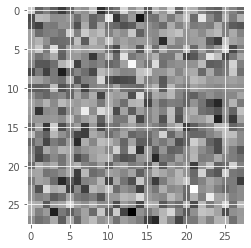

In [35]:
# show the output of model 
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.detach().reshape(2, 28, 28))
# Вывод необученного генератора
plt.imshow(gen_imgs[0], cmap='gray')
plt.show()

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# implement feauture matching from this paper: https://paperswithcode.com/method/feature-matching 
# define the criterion 
# Для генератора лосс выбирается для регуляризации feature matching
criterion_g_mse = nn.MSELoss()
criterion_g_bce = nn.BCELoss()
criterion_d = nn.BCELoss()
## Define the optimizer for generator and discrimator, Adam with weight_decay, amsgrad=True
optimizer_g = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

Discriminator Training

In [37]:
# Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample,
#  if it is real, then replace the label with a random number between 0.7 and 1.2, and 
#  if it is a fake sample, replace it with 0.0 and 0.3 (for example).
#make the labels the noisy for the discriminator: occasionally flip the labels when training the discriminator

In [38]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    optimizer_g.zero_grad()
    optimizer_d.zero_grad()
  

LABEL_SMOOTH = 0.95
def train_discriminator(images):
  
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)*LABEL_SMOOTH
    fake_labels = torch.ones(batch_size, 1).to(device)*(1- LABEL_SMOOTH)
        
    
    outputs = D(images).to(device)
    # Loss for real images
    d_loss_real = criterion_d(outputs, real_labels)
    real_score = torch.mean(outputs)

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z).to(device)
    outputs = D(fake_images).to(device)
    
    d_loss_fake = criterion_d(outputs, fake_labels)
    fake_score = torch.mean(outputs)

    # Sum losses
    loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Compute gradients
    loss.backward()

    # Adjust the parameters using backprop
    optimizer_d.step()
    
    return loss, real_score, fake_score

Generator Training

In [39]:
#Add guass noise
#noise = 0.005*np.random.uniform()*np.amax(sound)

In [40]:
# def train_generator(images):
#     # Generate fake images and calculate loss
#     # z = torch.randn(batch_size, latent_size).to(device)
#     z = np.random.normal(0, 1, (batch_size, latent_size))
#     noise = 0.005*np.random.uniform()*np.amax(z)
#     z = z.astype('float64') + noise*np.random.normal(size=z.shape)
#     z = torch.Tensor(z).to(device)
#     fake_images = G(z).to(device)
#     labels = torch.ones(batch_size, 1).to(device)
    
#     feature_real, _ = D(images, matching=True)
#     feature_fake, _ = D(fake_images, matching=True)
#     feature_real = torch.mean(feature_real,0)
#     feature_fake = torch.mean(feature_fake,0)
#     # calculate the generator loss
#     loss_mse = criterion_g_mse(feature_fake, feature_real)
#     # loss_bce = criterion_g_bce(D(fake_images), labels)
#     loss_bce = 0
#     loss = loss_mse + loss_bce
    
#     # Reset gradients
#     reset_grad()
#     # Backprop and optimize
#     loss.backward()
#     optimizer_g.step()

#     return loss, fake_images


criterion = nn.BCELoss()
def train_generator(images):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    # calculate the generator loss
    loss = criterion(D(fake_images), labels)
    
    # Reset gradients
    reset_grad()
    # Backprop and optimize
    loss.backward()
    optimizer_g.step()

    return loss, fake_images

## Start the training proccess

In [41]:
def save_fake_images(index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    z = np.random.normal(0, 1, (batch_size, latent_size))
    noise = 0.005*np.random.uniform()*np.amax(z)
    z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    fake_images = G(z)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [42]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator  
        d_loss, real_score, fake_score = train_discriminator(images)
        # Train the generator
        g_loss, _ = train_generator(images)
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 1.3628, g_loss: 0.7044, D(x): 0.51, D(G(z)): 0.50
Epoch [0/100], Step [400/600], d_loss: 1.3557, g_loss: 0.6990, D(x): 0.52, D(G(z)): 0.50
Epoch [0/100], Step [600/600], d_loss: 1.3507, g_loss: 0.7126, D(x): 0.51, D(G(z)): 0.49
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 1.3613, g_loss: 0.7051, D(x): 0.51, D(G(z)): 0.50
Epoch [1/100], Step [400/600], d_loss: 1.3621, g_loss: 0.7095, D(x): 0.51, D(G(z)): 0.49
Epoch [1/100], Step [600/600], d_loss: 1.3643, g_loss: 0.7022, D(x): 0.51, D(G(z)): 0.49
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 1.3672, g_loss: 0.7061, D(x): 0.50, D(G(z)): 0.49
Epoch [2/100], Step [400/600], d_loss: 1.3641, g_loss: 0.7049, D(x): 0.51, D(G(z)): 0.49
Epoch [2/100], Step [600/600], d_loss: 1.3606, g_loss: 0.7085, D(x): 0.51, D(G(z)): 0.49
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 1.3642, g_loss: 0.7067, D(x): 0.51, D(G(z)): 0.49
Epoch [3/100], Step [400/6

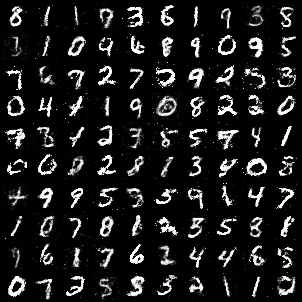

In [54]:
Image(os.path.join(sample_dir, 'fake_images-0099.png'))

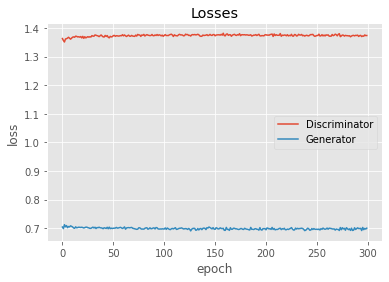

In [44]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

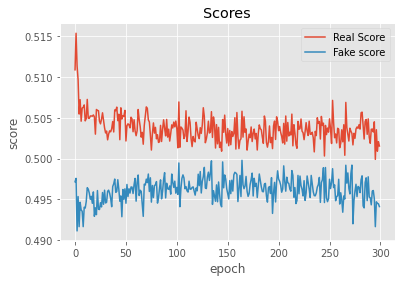

In [45]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');